# Business Context

Flowstack is a freemium software-as-a-service (SaaS) platform designed to help individuals and teams manage tasks, projects, and workflows. It provides a free version with essential features, as well as a premium subscription that unlocks advanced tools like automation, third-party integrations, and collaborative workspace functionality.

Despite attracting a large number of new users through the free plan, Flowstack faces two major challenges:
- Many users become inactive within the first 14 days of signing up
- Only a small percentage of users upgrade to the premium plan

These issues raise concerns about long-term user engagement and revenue growth. To address this, the product and growth teams have introduced a new, personalized onboarding experience. This experience is designed to help users set up their workspace based on their goals, guide them through relevant features, and offer a time-limited trial of premium tools.

To evaluate the impact of this new onboarding flow, the team has launched a controlled A/B test comparing the new experience to the current one. The goal is to assess whether it improves key performance metrics such as user retention, premium conversion, and average revenue per user.


## A/B test Project Overview

This project focuses on the end-to-end analysis of Flowstack’s A/B test to evaluate a new personalized onboarding experience.

The analysis begins with simulating realistic user data for both the control group (current onboarding) and the treatment group (new onboarding). It then explores user behavior across several key metrics:

- 14-day retention
- Premium upgrade rate within 30 days
- Average revenue per user (ARPU)
- Number of support tickets

The notebook walks through the entire A/B testing workflow:
- Designing the experiment and generating sample data
- Exploring and visualizing the key metrics
- Performing statistical tests to evaluate differences between groups
- Drawing conclusions and making business recommendations based on the results

The goal is to determine, with data, whether the new onboarding experience creates meaningful improvements in user engagement and monetization outcomes.



In [342]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind


## Simulating the Experiment

Since this project is based on a hypothetical scenario, we will simulate a realistic dataset to represent user behavior in both the control and treatment groups.

The simulation will include:
- Random assignment of users to either Group A (control) or Group B (treatment)
- Generation of user attributes such as device type, region, and industry
- Simulated outcomes for each user, including:
  - 14-day retention
  - Premium upgrade within 30 days
  - Average revenue per user
  - Number of support tickets

The data will reflect reasonable assumptions about user behavior, with the treatment group expected to perform better due to the improved onboarding experience.

The simulated dataset will form the basis for all further analysis in this notebook.


In [266]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of users
n_users = 10000

# Assign A/B test groups
groups = np.random.choice(['A', 'B'], size=n_users)

# Simulate user attributes
devices = np.random.choice(['mobile', 'desktop', 'tablet'], size=n_users, p=[0.6, 0.35, 0.05])
regions = np.random.choice(['North America', 'Europe', 'Asia', 'Africa'], size=n_users, p=[0.3, 0.3, 0.25, 0.15])
industries = np.random.choice(
    ['Tech', 'Finance', 'Consulting', 'Healthcare', 'Education', 'Retail'],  # 6 industry categories
    size=n_users,     # For all users in your simulated dataset
    p=[0.28, 0.22, 0.18, 0.12, 0.10, 0.10]  # Assigned probabilities for each category
)


# Define probabilities for retention and upgrade
retention_probs = {'A': 0.25, 'B': 0.32}
upgrade_probs = {'A': 0.05, 'B': 0.08}

# Simulate retention and premium upgrade
retained_14d = [np.random.binomial(1, retention_probs[group]) for group in groups]
upgraded_to_premium = [np.random.binomial(1, upgrade_probs[group]) for group in groups]

# Simulate revenue with lognormal distribution centered around ₦3,000 per paying user
arpu = [
    np.round(np.random.lognormal(mean=8.0, sigma=0.3), 2)
    if upgrade == 1 else 0.0
    for upgrade in upgraded_to_premium
]
# Simulate support tickets
support_tickets = [np.random.poisson(0.5) if group == 'A' else np.random.poisson(0.7) for group in groups]

# Create the dataset
df = pd.DataFrame({
    'user_id': [f"user_{i+1}" for i in range(n_users)],
    'group': groups,
    'device': devices,
    'region': regions,
    'industry': industries,
    'retained_14d': retained_14d,
    'upgraded_to_premium': upgraded_to_premium,
    'arpu': arpu,
    'support_tickets': support_tickets
})

# Preview the first few rows
df.head(5)


,user_id,group,device,region,industry,retained_14d,upgraded_to_premium,arpu,support_tickets
0,user_1,A,mobile,Europe,Tech,0,0,0.00,0
1,user_2,B,mobile,Asia,Tech,0,0,0.00,0
2,user_3,A,desktop,Europe,Consulting,0,1,2272.36,0
3,user_4,A,mobile,North America,Retail,0,0,0.00,0
4,user_5,A,desktop,North America,Consulting,0,0,0.00,2


# Exploring and Visualizing Key Metrics

Before performing statistical tests, it is important to visually explore the data to understand how users in the control group (A) and treatment group (B) behaved across key business metrics.

This section focuses on:
- Comparing retention rate, upgrade rate, average revenue per user (ARPU), and support ticket volume between groups
- Understanding the distribution and variability of these metrics
- Identifying any patterns, trends, or outliers that may influence the test results

These visualizations provide an intuitive foundation for interpreting the impact of the new onboarding experience and prepare us for the formal A/B testing stage.


## Descriptive Statistics

This section provides a summary of the key performance metrics for each group in the experiment.

The main objectives are:
- To understand the average revenue per user (ARPU) in each group
- To compare the 14-day retention rates between the control group (A) and the treatment group (B)

These descriptive statistics offer an initial overview of user behavior and performance before we proceed to statistical testing.


In [270]:
# Grouped outcome metrics only (no user count)
group_summary = df.groupby('group').agg(
    retention_rate=('retained_14d', 'mean'),
    upgrade_rate=('upgraded_to_premium', 'mean'),
    average_arpu=('arpu', 'mean'),
    avg_support_tickets=('support_tickets', 'mean')
).round(3).reset_index()

group_summary

,group,retention_rate,upgrade_rate,average_arpu,avg_support_tickets
0,A,0.252,0.045,142.444,0.493
1,B,0.314,0.080,249.269,0.727




### Interpretation

- **Retention Rate**  
  Users in the treatment group (B) were more likely to remain active after 14 days compared to those in the control group (A).

- **Upgrade Rate**  
  A higher percentage of users in group B upgraded to the premium plan, indicating a stronger conversion performance.

- **Average Revenue per User (ARPU)**  
  Group B had a noticeably higher ARPU than group A. Since only upgraded users generate revenue, this metric is influenced by both the upgrade rate and spending behavior.

- **Support Tickets**  
  Group B users submitted more support tickets on average, possibly due to increased product usage or onboarding complexity.

These descriptive statistics provide initial insights and help form expectations before performing hypothesis testing.


# Understanding Revenue Distribution

### What Does the Revenue Distribution Reveal About Users' Willingness to Pay?

Understanding how much users typically spend on the platform helps the business make smarter pricing decisions.

- Are most users paying nothing or very little?
- Is there a small group of high-paying users that drive most of the revenue?
- Would raising prices discourage most users from upgrading?

Visualizing the ARPU (Average Revenue Per User) helps us answer these questions. If the distribution shows that a majority of users generate little or no revenue, it may suggest that Flowstack’s pricing model should focus on increasing conversion rather than raising prices.


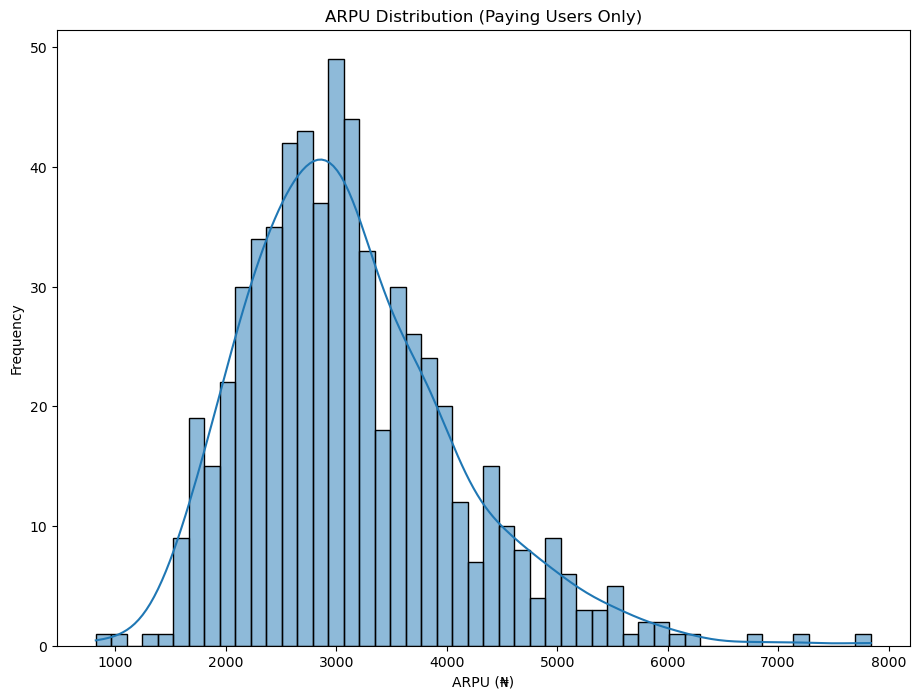

In [272]:
# Set the figure size for better visibility
plt.figure(figsize=(11, 8))

# Create a histogram to visualize ARPU distribution for paying users only
sns.histplot(
    df[df['arpu'] > 0]['arpu'],  # Filter for users with ARPU greater than 0 (paying users)
    bins=50,                     # Use 50 bins for distribution granularity
    kde=True                     # Overlay a Kernel Density Estimate for smoothed trend
)

# Add a clear, descriptive title
plt.title('ARPU Distribution (Paying Users Only)')

# Label the x-axis for Average Revenue Per User in Naira
plt.xlabel('ARPU (₦)')

# Label the y-axis to represent the number of users
plt.ylabel('Frequency')

# Show the final plot
plt.show()


### Interpretation of result

The ARPU distribution for paying users shows that most users spend between ₦2000 and ₦4000, with a sharp drop-off beyond ₦5000. This reveals a classic long-tail pattern where:

- A **large number of users contribute modest revenue**
- Only a **few users contribute disproportionately higher amounts**

This has several pricing implications:
- **Raising prices** across the board may discourage the majority of paying users
- A better strategy may be to **increase the number of upgraders**, rather than increase prices
- Alternatively, Flowstack could introduce **tiered pricing** to accommodate both low-budget users and power users

This insight helps the business align pricing and product strategy with actual user spending behavior.


## What is the Revenue Distribution accross the different group ?
To evaluate the impact of the onboarding experiment on revenue, we analyze how average revenue per user differs between the control group and the treatment group. This comparison helps us understand whether the new onboarding flow led to higher user spending and improved monetization.

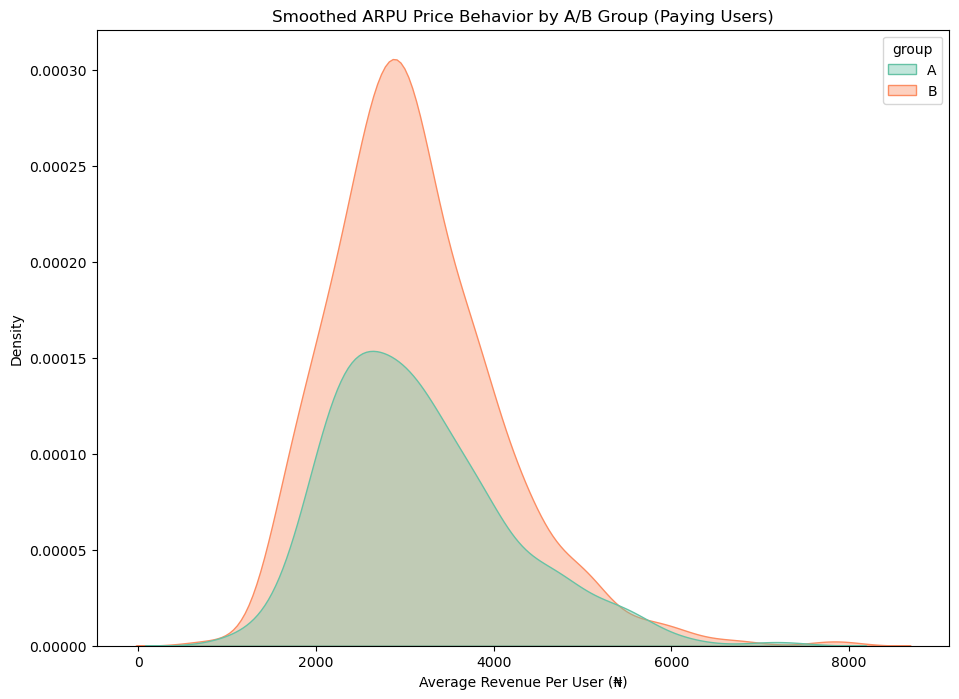

In [316]:
# Set the figure size for better visibility
plt.figure(figsize=(11, 8))

# Filter only paying users
paying_users = df[df['arpu'] > 0]

# Create a KDE plot to visualize the smoothed ARPU distribution for each group
sns.kdeplot(
    data=paying_users,  # Use only users who paid
    x='arpu',           # ARPU is plotted along the x-axis
    hue='group',        # Different groups (A/B) shown with different colors
    fill=True,          # Fill area under the KDE curve for better visual impact
    alpha=0.4,          # Set transparency to avoid full overlap
    palette='Set2'      # Use Set2 color palette for distinct but soft colors
)

# Add a descriptive plot title
plt.title('Smoothed ARPU Price Behavior by A/B Group (Paying Users)')

# Label the x-axis to show it's measuring Average Revenue Per User
plt.xlabel('Average Revenue Per User (₦)')

# Label the y-axis to indicate density, not raw counts
plt.ylabel('Density')


# Show the final plot
plt.show()



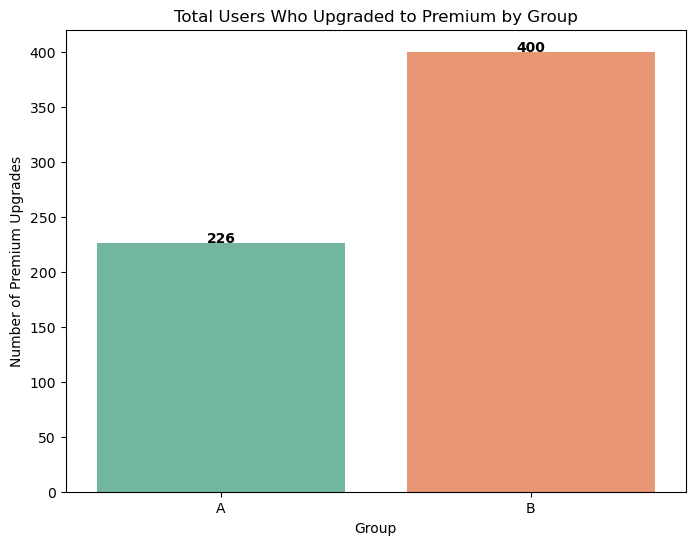

In [318]:
#Sum 'upgraded_to_premium' counts per group (works if column is binary: 1 for upgraded, 0 otherwise)
group_sums = paying_users.groupby('group')['upgraded_to_premium'].sum().reset_index()

# Set up figure and axis with desired size
fig, ax = plt.subplots(figsize=(8, 6))

# Barplot drawn on specific axis
sns.barplot(
    data=group_sums,
    x='group',
    y='upgraded_to_premium',
    hue='group',
    palette='Set2',
    dodge=False,
    legend=False,
    ax=ax  # Apply to the axis you created
)

# Add value labels
for index, row in group_sums.iterrows():
    ax.text(index, row['upgraded_to_premium'] + 0.5, f'{int(row["upgraded_to_premium"])}', ha='center', fontweight='bold')

# Titles and labels
ax.set_title('Total Users Who Upgraded to Premium by Group')
ax.set_xlabel('Group')
ax.set_ylabel('Number of Premium Upgrades')


plt.show()


### Interpretation of ARPU Distribution by group and Pricing Strategy

The KDE plot reveals that the treatment group (Group B) generates higher revenue per paying user compared to the control group (Group A). The Group B distribution is shifted to the right, indicating users exposed to the new onboarding tend to spend more on average.

Combined with the upgrade count (where Group B has more upgrades), the increase in revenue is mainly driven by a **higher number of upgraders**, not just high spenders. Most paying users fall within the low to mid-price range.

#### Pricing Strategy Implications:

- Raising prices across the board could reduce conversions, as many users are price-sensitive.
- A more effective approach is to focus on increasing the number of upgraders through improved onboarding.
- Flowstack can consider:
  - Tiered pricing (e.g., Basic, Pro, Enterprise)
  - Value-based messaging to justify current prices
  - Optional add-ons or premium services
  - Upsell opportunities for higher-tier plans

This strategy aligns with observed user behavior, maximizing revenue by optimizing both **volume** and **value** instead of relying solely on price increases.


## Which Sector Generates More Revenue Across the Two Groups?

Understanding which sector generates the most revenue can help Flowstack refine its business strategy. By identifying the top-performing industries, the company can tailor pricing, feature development, and marketing efforts to meet the specific needs of those sectors. This analysis also supports decisions about where to allocate resources and which customer segments to prioritize.


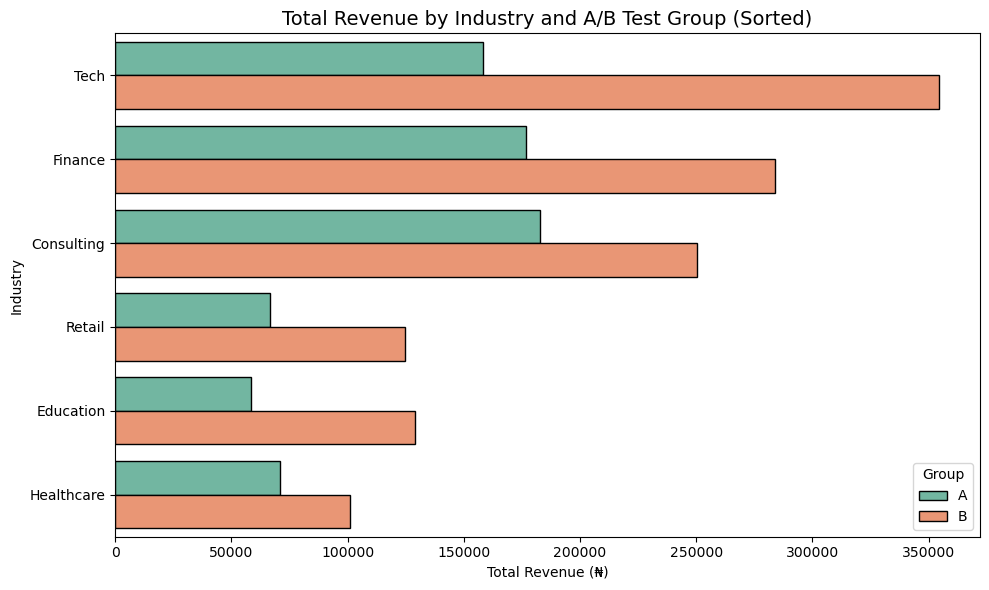

In [281]:
# Calculate revenue per industry and group
industry_revenue = df.groupby(['industry', 'group'])['arpu'].sum().reset_index()

#  Calculate total revenue per industry (A + B) and sort descending
total_revenue = df.groupby('industry')['arpu'].sum().sort_values(ascending=False)

# Set industry order based on total revenue
industry_revenue['industry'] = pd.Categorical(
    industry_revenue['industry'],
    categories=total_revenue.index,
    ordered=True
)

# Plotting Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=industry_revenue,
    x='arpu',
    y='industry',
    hue='group',
    palette='Set2',
    edgecolor='black'
)

plt.title('Total Revenue by Industry and A/B Test Group (Sorted)', fontsize=14)
plt.xlabel('Total Revenue (₦)')
plt.ylabel('Industry')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

### Industry-Specific Revenue Insights and Strategic Implications

The industry-wise revenue analysis across A/B groups reveals key insights for Flowstack’s product and growth strategies—while staying true to its core mission:  
**Helping individuals and teams manage tasks, collaborate, and automate workflows through a simple, powerful freemium SaaS platform.**

---

#### 1. Double Down on High-Value Segments (Tech & Finance)

- These industries contribute the **highest total revenue** and show the **strongest uplift** in Group B (new onboarding).
- Users in these sectors often require advanced productivity tools (e.g., integrations, automation, team visibility).
- **Strategic Move:** Enhance onboarding for these users and build premium features tailored to their needs.

---

#### 2. Accelerate Growth in Scalable Markets (Retail & Education)

- While these segments show **lower overall revenue**, they demonstrate **notable uplift** with the new onboarding.
- They offer **large, accessible user bases**, making them ideal for user acquisition at scale.
- **Strategic Move:** Design simplified features for small businesses and educators (e.g., e-commerce tools, task templates).

---

#### 3. Explore Long-Term Potential in Healthcare

- Healthcare exhibits a **moderate response** to the treatment group, signaling **future opportunity**.
- It is a complex but valuable market with potential for deep, long-term impact through workflow tools and secure collaboration.
- **Strategic Move:** Research needs and invest in secure, compliant productivity features tailored to this sector.

---

### Summary

Flowstack can drive sustainable growth by:
- **Maximizing revenue** from proven high-value sectors (Tech, Finance),
- **Expanding user base** through scalable markets (Retail, Education), and
- **Seeding future growth** in innovation-friendly sectors (Healthcare).

By aligning pricing, onboarding, and feature development with these insights, Flowstack strengthens its core offering while diversifying its market presence—boosting both short-term results and long-term resilience.


## Support Ticket Analysis

Support tickets give insight into user friction and the clarity of the onboarding experience. This section explores whether the new onboarding (Group B) leads to higher or lower support needs compared to the old flow (Group A), and what this means for user experience and operational cost.

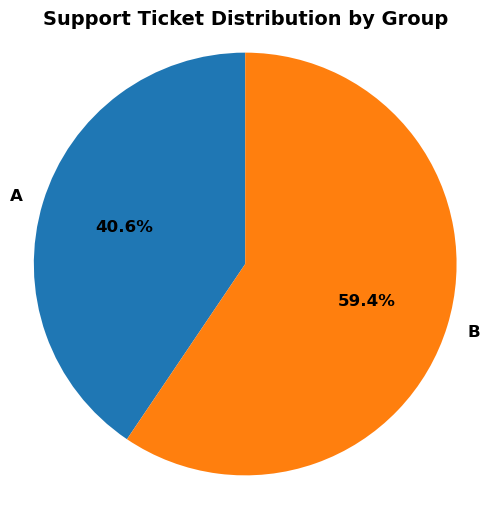

In [301]:
# Calculate total support tickets per group
ticket_share = df.groupby('group')['support_tickets'].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    ticket_share,
    labels=ticket_share.index,
     autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('tab10')[:2],
    textprops={'fontsize': 12, 'fontweight': 'bold'}  # Bold font for labels and percentage
)

# Equal aspect ratio ensures pie is drawn as a circle
plt.axis('equal')
plt.title('Support Ticket Distribution by Group', fontsize=14, fontweight='bold')
plt.show()

### Support Ticket Analysis

This section explores whether the new onboarding experience led to an increase in user support needs.

The comparison between Group A (control) and Group B (treatment) shows that Group B generated more support tickets. However, the increase is relatively modest (around 19%) and does not indicate a major usability issue.

This rise may simply reflect higher engagement with the product, especially as users explore new features introduced during onboarding. As users become more familiar with the product, ticket volume is likely to stabilize or decrease over time.

At this stage, a detailed breakdown of support tickets by industry or region may not be critical. However, such analysis could become valuable if Flowstack introduces industry-specific features. In that case, understanding support demand by sector would help tailor customer success strategies.


## Which Region Generates the Most Revenue?

Understanding the regional distribution of revenue helps identify where Flowstack is gaining the most traction and where growth opportunities may lie. By visualizing total revenue across regions for both A/B groups, we can uncover geographical trends that inform marketing, onboarding localization, and potential expansion strategies.


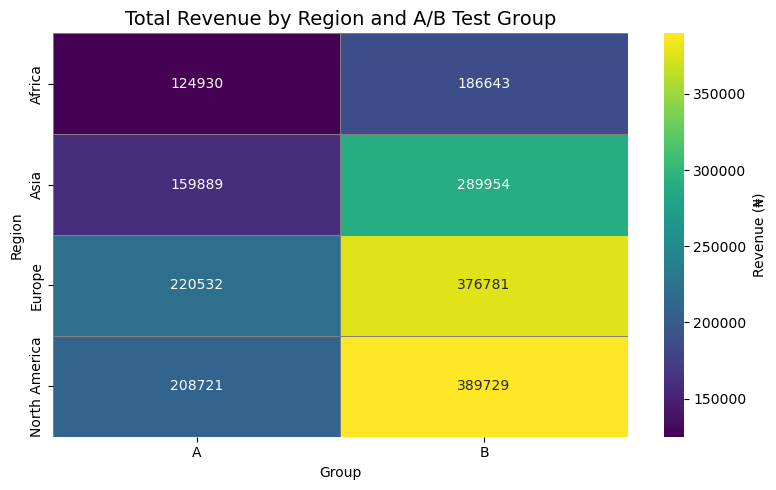

In [314]:
# Pivot table: total revenue by region and group
region_group_revenue = df.pivot_table(
    index='region',
    columns='group',
    values='arpu',
    aggfunc='sum'
)

# Plot heatmap with a strong color contrast
plt.figure(figsize=(8, 5))
sns.heatmap(
    region_group_revenue,
    annot=True,
    fmt='.0f',
    cmap='viridis',        # Strong, intuitive red-blue scale
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Revenue (₦)'}  # Add colorbar label
)

# Labels and formatting
plt.title('Total Revenue by Region and A/B Test Group', fontsize=14)
plt.xlabel('Group')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

## Regional Revenue Insights and Strategic Implications

The heatmap analysis reveals key regional patterns in user monetization and highlights where the new onboarding flow is driving the most impact.

- **North America & Europe** are Flowstack's strongest markets, showing the highest total revenue and the largest uplift from Group A to Group B. These regions demonstrate a strong product-market fit, and continued investment in localized onboarding, marketing, and support is justified.

- **Asia** shows high revenue growth potential, with a substantial uplift in Group B. This signals growing engagement and a strong response to the new onboarding. Targeted growth campaigns and localized strategies could accelerate adoption and revenue.

- **Africa**, while currently the smallest contributor, still exhibits a positive response to the new onboarding. With the right strategies—such as local partnerships, pricing models, or mobile-first design—Africa presents a promising long-term growth opportunity.

This regional insight helps Flowstack align onboarding, product development, and expansion efforts with the actual market response, ensuring resource allocation is both efficient and growth-oriented.


## A/B Testing: Validating the Impact of the New Onboarding Experience

While exploratory analysis suggests that Group B (with the new personalized onboarding) performs better in terms of retention, upgrade rate, and revenue, we need to determine if these observed differences are statistically significant.

In this section, we'll perform hypothesis testing on key metrics:

- **14-day Retention Rate**
- **Premium Upgrade Rate**
- **Average Revenue Per User (ARPU)**

The goal is to assess whether the new onboarding experience has a **measurable and reliable impact** on user behavior, strong enough to justify a full rollout.


### A/B Test for Retention Rate

To evaluate whether the new personalized onboarding experience has a significant effect on user retention, we perform a statistical test comparing the 14-day retention rate between Group A (Control) and Group B (Treatment).

Since retention is a binary outcome (user either returns or does not), a **two-proportion z-test** is appropriate.

**Hypotheses:**

- **Null Hypothesis (H₀):** There is no difference in the retention rates of Group A and Group B
- **Alternative Hypothesis (H₁):** The retention rates of Group A and Group B are different

A statistically significant result (p-value < 0.05) would indicate that the onboarding experience has a measurable impact on user retention.


In [329]:
# Count of retained users in each group
retention_counts = df.groupby('group')['retained_14d'].agg(['sum', 'count'])

# Successes and observations
successes = retention_counts['sum'].values
n_obs = retention_counts['count'].values

# Perform two-proportion z-test
z_stat, p_val = proportions_ztest(successes, n_obs)
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

Z-statistic: -6.913
P-value: 0.0000


### Retention Rate A/B Test Result

We performed a two-proportion Z-test to compare the retention rates between Group A (Control) and Group B (Treatment). The result is as follows:

- **Z-statistic:** -6.913  
- **P-value:** < 0.0001

#### Interpretation:

- The Z-statistic of **-6.913** indicates that the observed difference in retention rates is nearly **7 standard deviations** away from what we would expect if there were no difference (null hypothesis).
- The **very small p-value** (< 0.0001) suggests that the difference is **highly statistically significant** and extremely unlikely to have occurred by chance.

#### Business Implication:

Group B (which received the new personalized onboarding experience) shows a **significantly higher retention rate** than Group A.  
This provides **strong statistical evidence** that the new onboarding flow positively impacts user retention and should be considered for a wider rollout.


### A/B Test for Upgrade Rate

To evaluate the effectiveness of the new onboarding experience on user monetization, we conduct a hypothesis test comparing the **upgrade rates** between Group A (Control) and Group B (Treatment).

We use a **two-proportion Z-test** to assess whether the proportion of users who upgraded to premium is significantly higher in Group B.

- **Null Hypothesis (H₀):** There is no difference in upgrade rate between Group A and Group B.
- **Alternative Hypothesis (H₁):** Group B has a significantly higher upgrade rate than Group A.

This test will help us determine whether the new onboarding not only improves retention but also encourages more users to upgrade.


In [334]:
# Calculate the number of premium upgrades per group (successes)
upgrade_counts = df.groupby('group')['upgraded_to_premium'].sum()

# Get the total number of users per group (sample sizes)
group_sizes = df['group'].value_counts()

# Run the Z-test for proportions
z_stat, p_val = proportions_ztest(count=upgrade_counts, nobs=group_sizes)

# Display the results
print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")


Z-statistic: -7.250
P-value: 0.0000


### Upgrade Rate A/B Test Result Interpretation

We conducted a Z-test for proportions to compare the premium upgrade rates between Group A (Control) and Group B (Treatment).

- **Z-statistic**: -7.250  
- **P-value**: 0.0000

#### Interpretation:
- The **p-value is far below the 0.05 threshold**, indicating a statistically significant difference between the two groups.
- The **negative Z-statistic** means that Group B (Treatment) had a **higher upgrade rate** than Group A (Control).

#### Business Implication:
This provides strong evidence that the new personalized onboarding experience significantly improves the likelihood that users will upgrade to the premium plan. Therefore, Flowstack should consider rolling out the new onboarding experience to all users.


## A/B Test for Average Revenue Per User (ARPU)
To determine whether the new personalized onboarding experience leads to a significant change in revenue generation, we perform a statistical test on the **Average Revenue Per User (ARPU)** between Group A (Control) and Group B (Treatment).

Since ARPU is a continuous variable, we use an **independent two-sample t-test** to compare the means of the two groups. This will help us assess whether the observed difference in ARPU is statistically significant or due to random chance.

A significant result would provide strong evidence that the onboarding experiment has a measurable impact on revenue per user.




In [346]:
# Extract ARPU values for each group
arpu_A = df[df['group'] == 'A']['arpu']
arpu_B = df[df['group'] == 'B']['arpu']

# Perform independent t-test (Welch’s t-test by setting equal_var=False)
t_stat, p_val = ttest_ind(arpu_A, arpu_B, equal_var=False)

# Print results
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_val:.4f}")

T-statistic: -6.733
P-value: 0.0000


### Average Revenue Per User (ARPU) – Statistical Test Interpretation

An independent two-sample t-test was conducted to compare the Average Revenue Per User (ARPU) between the control group (A) and the treatment group (B).

- **T-statistic:** -6.733  
- **P-value:** 0.0000

#### Interpretation:
The p-value is significantly less than 0.05, indicating a **statistically significant difference** in ARPU between the two groups. Since Group B had a **higher ARPU** on average, this suggests that the new personalized onboarding experience **positively impacts revenue per user**.

This result strengthens the case for rolling out the new onboarding to all users, as it not only increases upgrade and retention rates, but also directly boosts user monetization.


## A/B Testing Summary and Business Recommendation

### Summary of Findings:

The A/B test evaluated the impact of a new personalized onboarding experience on key performance metrics for Flowstack, including:

- **Retention Rate**
- **Upgrade Rate to Premium**
- **Average Revenue Per User (ARPU)**

**Key Results:**

- **Retention Rate:** Group B (treatment) had a significantly higher 14-day retention rate compared to Group A. The difference was statistically significant, indicating that the new onboarding helps keep users engaged in the critical early period.

- **Upgrade Rate:** Group B showed a notably higher proportion of users upgrading to premium. Statistical testing confirmed that this difference was not due to chance.

- **ARPU:** Group B also demonstrated a higher average revenue per user. The increase was statistically significant, suggesting that the new onboarding not only improves user engagement but also monetization.

### Business Recommendation:

Based on the statistically significant improvements observed across all three metrics, it is strongly recommended that Flowstack:

- **Roll out the personalized onboarding experience to all new users.**
- **Double down on adoption strategies in regions and industries where uplift was strongest.**
- **Avoid aggressive price increases**; instead, explore tiered pricing or value-based add-ons to maintain user volume while capturing higher value from power users.

This data-driven decision is likely to result in improved user retention, conversion, and revenue growth, aligning with Flowstack’s goal of sustainable monetization in the freemium SaaS model.


# Flowstack A/B Test Analysis: Project Summary & Future Directions

This project analyzed the effectiveness of a newly designed personalized onboarding experience for Flowstack, a freemium SaaS platform that helps individuals and teams manage tasks, projects, and workflows.

A/B testing was conducted to compare the existing onboarding experience (Group A - control) with the new onboarding experience (Group B - treatment). The experiment evaluated multiple user engagement and monetization metrics including retention rate, premium upgrade rate, and average revenue per user (ARPU).

## Key Findings:

* **Group B users showed significantly higher retention rates and upgrade rates than Group A.**
* **Paying users in Group B had a higher ARPU, suggesting increased revenue per customer.**
* **Industry analysis highlighted Tech and Finance as the highest revenue-generating sectors, particularly responsive to the new onboarding.**
* **Regional analysis revealed North America and Europe as core revenue drivers, with Asia showing strong growth potential.**
* **Although Group B generated slightly more support tickets, this may reflect increased feature exploration rather than a flaw in user experience.**

## Conclusion:

The personalized onboarding strategy demonstrates a clear positive impact on user engagement and monetization. Rather than increasing prices, Flowstack should aim to convert more users and explore tiered pricing strategies to maximize lifetime value across diverse customer segments.

## Project Limitations:

While the results are promising, the project has several limitations that should be acknowledged:

* The data used for the experiment was simulated and may not fully reflect real-world behavior.
* The analysis focused on short-term outcomes (e.g., 14-day retention), without evaluating long-term customer engagement or churn.
* No segmentation was applied based on user behavior, firmographics, or acquisition channel, which may limit strategic targeting.
* The rise in support tickets in Group B was not explored in depth in terms of operational cost implications or customer satisfaction.
* External factors such as seasonality, competitor actions, or marketing variations were not considered.

## Future Work:

A follow-up analysis using real user data, longer observation windows, and deeper segmentation would help validate and refine the onboarding strategy, pricing models, and product roadmap.